### Проведение АА-тестирования между группами: период с 26.08.2025 по 01.09.2025

In [ ]:
#Функция для сплитования 
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [6]:
import pandahouse
import swifter
import hashlib
import seaborn as sns
import scipy.stats
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt

In [7]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250920'
}

q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) >= '2025-08-26' and toDate(time) <= '2025-09-01' 
"""

# Вытащили пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

# Сделали группы
users_df['hash_group'] = users_df.user_id.swifter.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

Pandas Apply:   0%|          | 0/41997 [00:00<?, ?it/s]

,hash_group,user_id
0,0,8588
1,1,8254
2,2,8397
3,3,8305
4,4,8453


In [8]:
#CTR в группах 2 и 3
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-08-26' and '2025-09-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


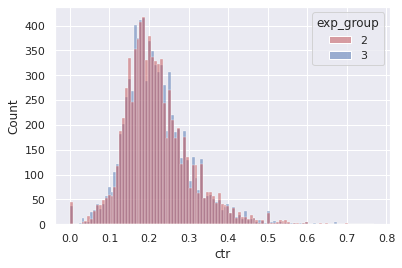

In [9]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

=== ПРОВЕРКА 1: Многократный t-test ===
Доля статистически значимых результатов (p < 0.05): 0.0451 (4.51%)
Количество значимых результатов: 451 из 10000


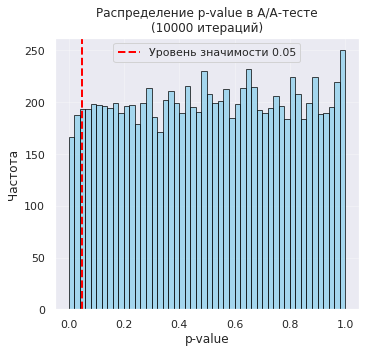

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

print("=== ПРОВЕРКА 1: Многократный t-test ===")
p_values = []
n_iterations = 10000
sample_size = 500

for i in range(n_iterations):
    # Берем подвыборки без возвращения из предварительно отфильтрованных данных
    sample_2 = df[df.exp_group == 2].ctr.sample(n=sample_size, replace=False, random_state=i)
    sample_3 = df[df.exp_group == 3].ctr.sample(n=sample_size, replace=False, random_state=i+10000)
    
    # Проводим t-тест
    t_stat, p_value = stats.ttest_ind(sample_2, sample_3, equal_var=False)
    p_values.append(p_value)

significant_results = sum(np.array(p_values) < 0.05)
proportion_significant = significant_results / n_iterations

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(p_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Уровень значимости 0.05')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.title('Распределение p-value в А/А-тесте\n(10000 итераций)')
plt.legend()
plt.grid(alpha=0.3)

print(f"Доля статистически значимых результатов (p < 0.05): {proportion_significant:.4f} ({proportion_significant*100:.2f}%)")
print(f"Количество значимых результатов: {significant_results} из {n_iterations}")

### Проведение АB-тестирования между группами 1 и 2: период с 02.09.2025 по 08.09.2025

In [11]:
#Создали подключение
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250920'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250920.feed_actions 
WHERE toDate(time) between '2025-09-02' and '2025-09-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#T-тест

stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

#### **Результаты**:
* t-тест: p-value = 0.685 → по тесту нет значимых различий
* t-тест может быть не значим, потому что:

> * Предполагает нормальность распределения
> * Чувствителен к выбросам
> * CTR обычно имеет тяжелые хвосты и много нулей

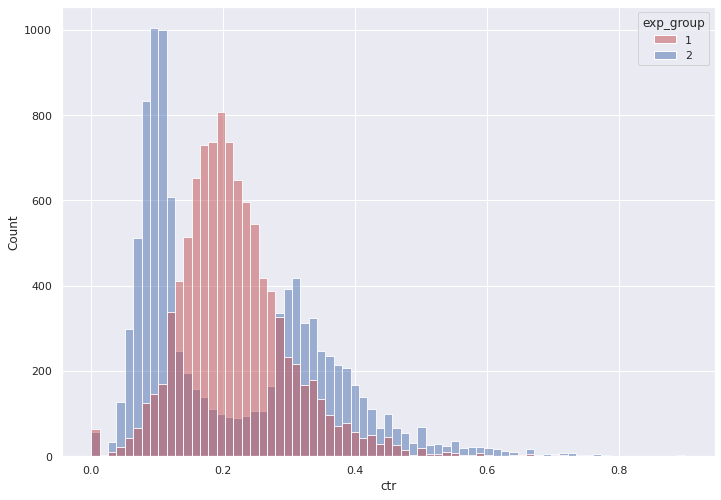

In [58]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### **Выводы**:
* распределения в группах действительно различаются на первый взгляд
* также распределения на вид ненормальные, содержат выбросы и шумы, поэтому t-test, скорее всего, не имеет значимого эффекта. 
* для такого случая существует непараметрический тест - используем тест Манна-Уитни.

In [59]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

#### **Манн-Уитни значим, так как:**

* Непараметрический тест

* Работает с рангами, а не значениями

* Устойчив к выбросам и ненормальным распределениям

* Видит разницу в "форме" распределения, а не только в средних

<Axes: xlabel='ctr', ylabel='Count'>

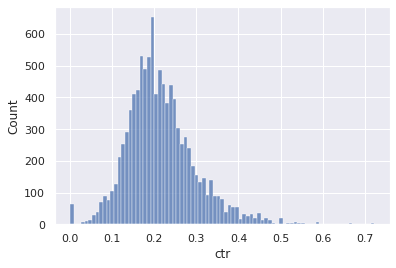

In [19]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-09-02' and '2025-09-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
sns. histplot(group1.ctr, 
             kde = False)


<Axes: xlabel='smothed_ctr', ylabel='Count'>

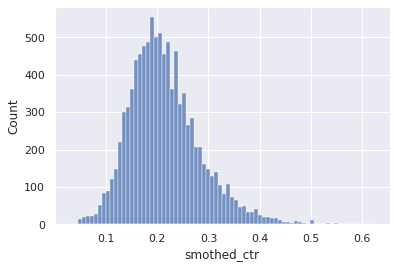

In [20]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_ctr, 
             kde = False)

<Axes: xlabel='ctr', ylabel='Count'>

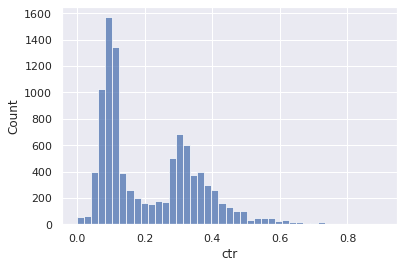

In [21]:
group2 = df[df.exp_group == 2].copy()
sns. histplot(group2.ctr, 
             kde = False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

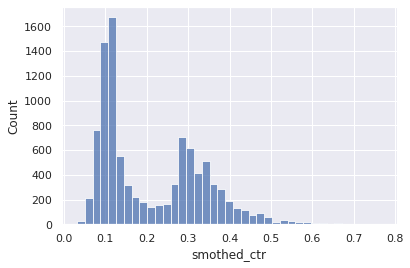

In [24]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_ctr, 
             kde = False)

In [25]:
# T-тест Стьюдента
t_stat, p_value = stats.ttest_ind(group1.smothed_ctr, 
                                 group2.smothed_ctr, 
                                 equal_var=False)
print(f"T-student result: statistic = {t_stat}, p-value={p_value}")

# Тест Манна-Уитни
mw_stat, mw_pvalue = stats.mannwhitneyu(group1.smothed_ctr, 
                                       group2.smothed_ctr,
                                       alternative='two-sided')
print(f"Mann-Whitney result: statistic={mw_stat:}, p-value={mw_pvalue}")

T-student result: statistic = 1.9460491517027683, p-value=0.05166679015318526
Mann-Whitney result: statistic=55528353.0, p-value=2.396534039374286e-50


#### **После сглаживания оба теста стали значимыми. Это говорит о том, что:**

* Разница реально существует между группами. Хоть и p-value при Стьюдента не такой маленький, как при Манна-Уитни - он стал гораздо меньше, и почти прокрасился.

* Проблема была в шуме и выбросах в исходных данных

* Сглаживание помогло "очистить" сигнал

<Axes: ylabel='Count'>

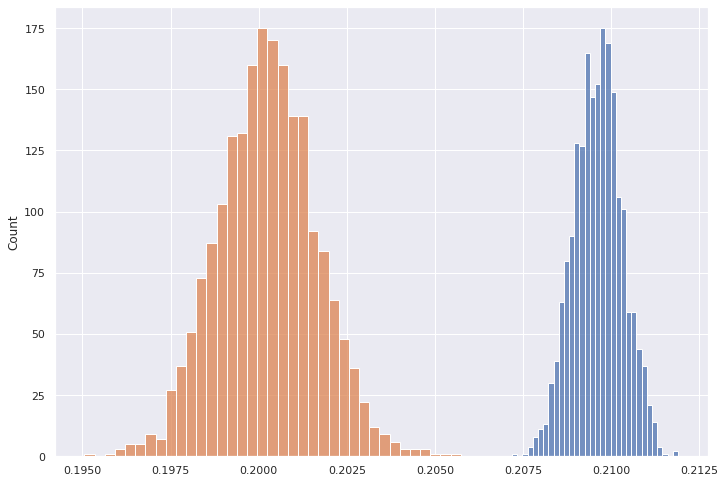

In [62]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-09-02' and '2025-09-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

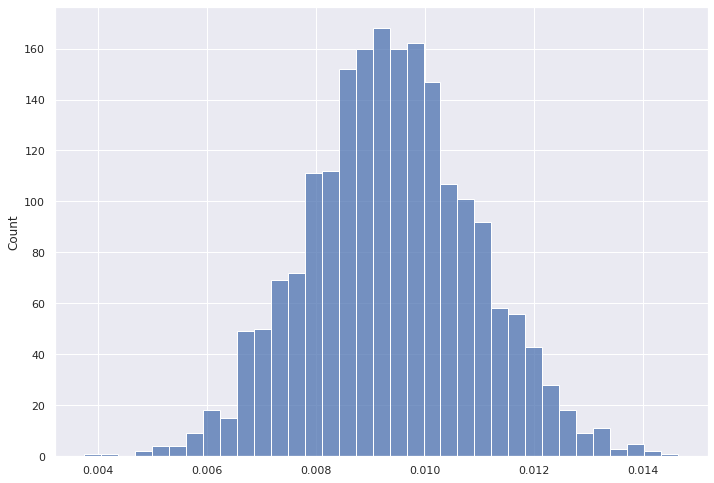

In [63]:
#Разница между глобальными CTR

sns.histplot(ctr1 - ctr2)

#### **Выводы**:
* Распределения не пересекаются - значит, различия точно есть.
* Разница между распределениями не пересекают ноль.

In [64]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-09-02' and '2025-09-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [65]:
#Т-тест Стьюдента также видит отличие
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

#### **Результаты**:
Бакетное преобразование также показал различия между группами. 

<Axes: xlabel='bucket_ctr', ylabel='Count'>

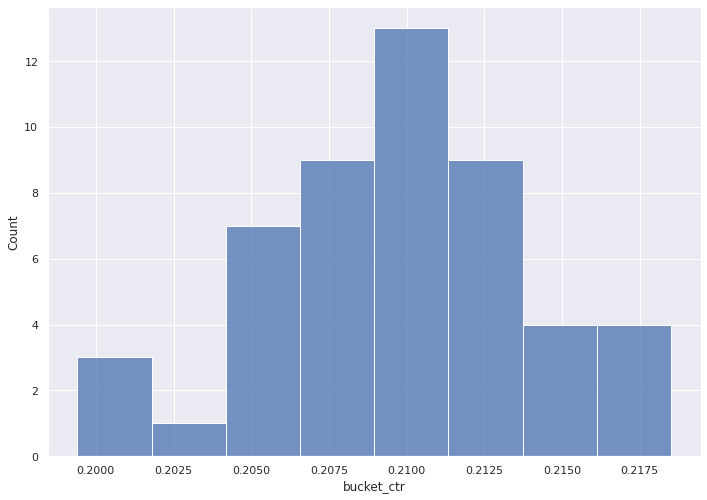

In [71]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<Axes: xlabel='ctr9', ylabel='Count'>

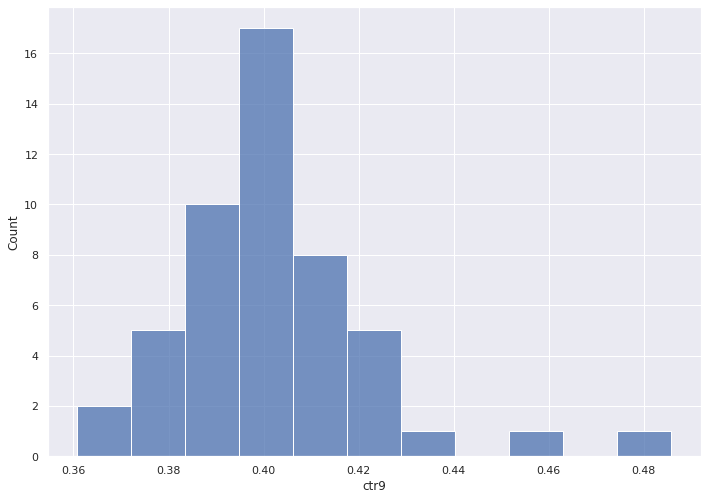

In [69]:
sns.histplot(df[df.exp_group == 2].ctr9)

## 🔍 Интерпретация результатов

### Почему алгоритм стал лучше, возможные сценарии.

> * **Алгоритм стал лучше подбирать релевантный контент.**
> * **Такая ситуация вполне ожидаема при успешной оптимизации рекомендательной модели.**
> * **Пользователи чаще лайкают, потому что видят то, что им реально интересно.**
> * **Алгоритм может сместить баланс в пользу «вирального» контента.** 
> * **Лента может чаще показывать развлекательные посты или короткий контент, который проще лайкнуть.** 
> * **В итоге CTR растёт, но это не обязательно значит, что пользователи проводят больше времени или глубже вовлекаются.**


## 📈 Рекомендации:

### 🟢 **Раскатывать новый алгоритм на всех пользователей**

**Новый алгоритм (группа 2) стоит раскатывать на всех пользователей.
Ожидается стабильное увеличение CTR.
Однако рекомендуется дополнительно мониторить метрики вовлеченности (удержание, глубину просмотра, время в ленте), чтобы убедиться, что рост CTR не сопровождается негативными эффектами.**

In [87]:
ctr_control = df[df.exp_group.isin([0,1])].likes.sum() / df[df.exp_group.isin([0,1])].views.sum()
round(ctr_control, 2)

0.21